In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import re

In [2]:
trees = pd.read_csv("stuff/original_trees.csv")

In [ ]:
#trees.head()

In [ ]:
#trees.describe()

In [3]:
del trees['Unnamed: 3']
del trees['Unnamed: 4']

In [5]:
print len(trees.ID.unique()), len(trees.ID), len(trees.ID.dropna())
tmp = trees.groupby('ID').size()
print tmp[tmp>1]
# remove the duplicate -- rather than sort it out
trees = trees[trees.ID!='H20367']

11710 11711 11711
ID
H20367    2
dtype: int64


In [6]:
trees.set_index(['ID'], inplace=True)

In [11]:
farmers = pd.read_csv("stuff/original_farmers.csv")

In [ ]:
farmers.describe()

In [ ]:
farmers.head()

In [12]:
farmers.rename(columns={'Household ID': 'ID'}, inplace=True)

In [14]:
# some farm ids are duplicated because there are multiple farmers 
# removed them as opposed to trying to sort out what's going on 
print len(farmers.ID.unique()), len(farmers.ID), len(farmers.ID.dropna())
tmp = farmers.groupby('ID').size()
tmp = set(list(tmp[tmp>1].index))
farmers = farmers.ix[farmers.ID.apply(lambda x: x not in tmp),:]
farmers = farmers[~farmers.ID.isnull()]

10436 10436 10436


In [15]:
farmers.set_index(['ID'], inplace=True)

In [16]:
farmers_trees = farmers.join(trees, how='inner')

In [17]:
print len(farmers), len(trees), len(farmers_trees)

10436 11709 10436


# OUTCOME (Yield)

In [21]:
yield_2016 = farmers_trees['2016'].copy()
yield_2016[farmers_trees['2016']==0] = np.nan

print len(farmers_trees['2016']), len(farmers_trees['2016'].dropna()), len(yield_2016.dropna())

yield_2015 = farmers_trees['2015'].copy()
yield_2015[farmers_trees['2015']==0] = np.nan

print len(farmers_trees['2015']), len(farmers_trees['2015'].dropna()), len(yield_2015.dropna())

10436 10434 5474
10436 10432 5152


In [25]:
farmers_trees['yield_average'] = [np.nanmean(yields) for yields in zip(yield_2015, yield_2016)]
farmers_trees['yield_2015'] = yield_2015
farmers_trees['yield_2016'] = yield_2016

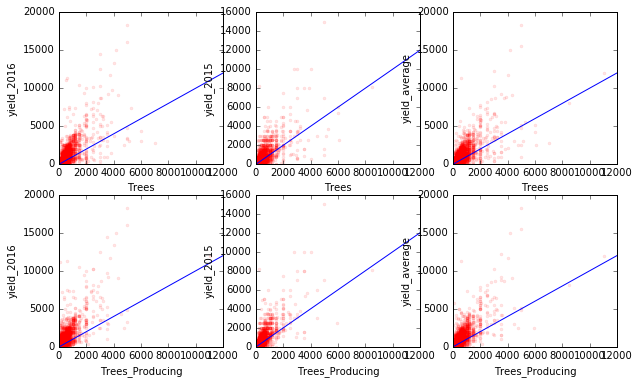

In [31]:
# The more trees you have the higher your yield
plt.figure(figsize=[10,6])
s = 1
for t in ['Trees', 'Trees_Producing']:
    for y in ['yield_2016', 'yield_2015', 'yield_average']:
        plt.subplot(230+s)
        plt.plot(farmers_trees[t], farmers_trees[y], 'r.', alpha=.1)
        plt.xlabel(t); plt.ylabel(y)
        plt.plot([0,12000], [0,12000])
        s = s+1

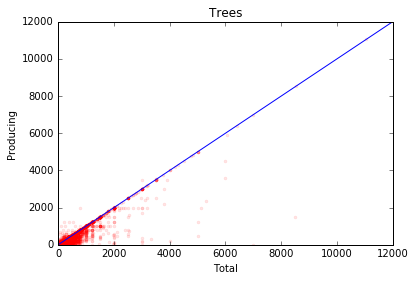

In [32]:
# Trees_Producing < Trees, usually
plt.plot(farmers_trees.Trees, farmers_trees.Trees_Producing, 'r.', alpha=.1)
plt.ylabel("Producing"); plt.xlabel("Total"); plt.title("Trees"); plt.plot([0,12000], [0,12000])

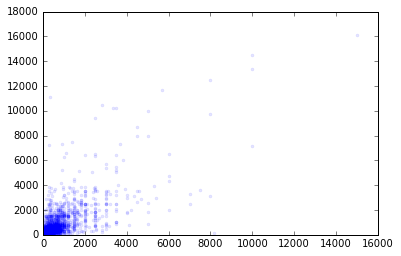

In [123]:
plt.plot(farmers_trees['yield_2015'],farmers_trees['yield_2016'],'b.',alpha=.1)

(0, 10)

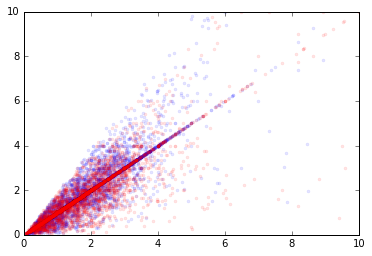

In [35]:
# an average is a much different measure than a single measurement
plt.plot(farmers_trees['yield_average']/farmers_trees['Trees'],
         farmers_trees['yield_2016']/farmers_trees['Trees'],'b.', alpha=.1)
plt.plot(farmers_trees['yield_average']/farmers_trees['Trees'],
         farmers_trees['yield_2015']/farmers_trees['Trees'],'r.', alpha=.1)
plt.xlim([0,10]); plt.ylim([0,10])

In [38]:
farmers_trees['ypt_2016'] = farmers_trees['yield_2016']/farmers_trees['Trees']
farmers_trees['ypt_2015'] = farmers_trees['yield_2015']/farmers_trees['Trees']
farmers_trees['ypt_average'] = farmers_trees['yield_average']/farmers_trees['Trees']
farmers_trees['yptp_2016'] = farmers_trees['yield_2016']/farmers_trees['Trees_Producing']
farmers_trees['yptp_2015'] = farmers_trees['yield_2015']/farmers_trees['Trees_Producing']
farmers_trees['yptp_average'] = farmers_trees['yield_average']/farmers_trees['Trees_Producing']

In [39]:
farmers_trees.columns

Index([u'Station', u'Staff', u'Group ID', u'Farmer Name', u'Attendance',
       u'Adoption', u'2015', u'2016', u'Course Attended', u'Trees',
       u'Trees_Producing', u'yield_2015', u'yield_2016', u'yield_average',
       u'ypt_2016', u'ypt_2015', u'yptp_2016', u'yptp_2015', u'ypt_average',
       u'yptp_average'],
      dtype='object')

In [45]:
print sum(farmers_trees.Trees_Producing.isnull()), sum(farmers_trees.Trees.isnull()), sum(farmers_trees.Trees_Producing == 0), sum(farmers_trees.Trees == 0)

880 23 259 1


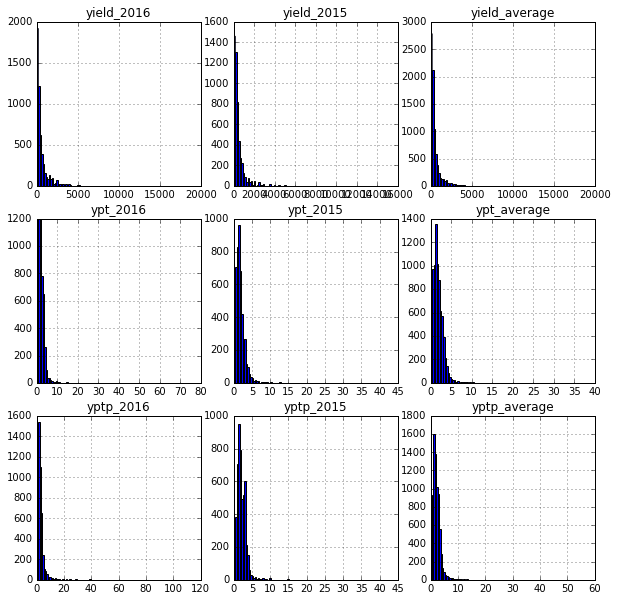

In [59]:
plt.figure(figsize=[10,10])
s=1
for y in ['yield_2016','yield_2015','yield_average','ypt_2016','ypt_2015','ypt_average','yptp_2016','yptp_2015','yptp_average']:
    farmers_trees[y].replace(np.inf, np.nan) 
    plt.subplot(330+s)
    farmers_trees[y].hist(bins=100)
    plt.title(y)
    s = s+1
    #plt.xlim([0,10])
plt.tight_layout()

# TREATMENTS (Yield)

In [63]:
farmers_trees['intercept'] = np.ones([len(farmers_trees),1])

In [72]:
courses_taken = farmers_trees['Course Attended'].copy()
courses_taken[courses_taken.isnull()] = '\n'
courses_taken = courses_taken.apply(lambda x: x.replace(" ", ""))
courses_taken = courses_taken.apply(lambda x: x.replace("\n\n", "\n"))
courses_taken = courses_taken.apply(lambda x: x.replace("&", "AND"))
courses_taken = courses_taken.apply(lambda x: x.replace("(", ""))
courses_taken = courses_taken.apply(lambda x: x.replace(")", ""))
courses_taken[courses_taken.apply(lambda x : x.find('0') != -1)] = "\n"
courses_taken = courses_taken.apply(lambda x : x+"\n")
courses_taken = courses_taken.apply(lambda x: x.replace("\nNutritionANDMulching\n", "\nMulching\n"))
courses_taken = courses_taken.apply(lambda x: x.replace("\nClimateChange\n", "\nAdaptingtoClimateChange\n"))
courses_taken = courses_taken.apply(lambda x: x.replace("\nClimateChange\n", "\nAdaptingtoClimateChange\n")) # the first is not enough
courses_taken = courses_taken.apply(lambda x: x.replace("\nTransparencyStandardsANDGroupGoalSetting\n", "\nTransparentSupplyChainANDPricing\n"))
courses_taken

ID
H0001     \nErosionControl\nPostHarvesting\nIntegratedPe...
H0003                                                  \n\n
H0004                                                  \n\n
H0006     \nShadeManagement\nPostHarvesting\nAdaptingtoC...
H0007     \nShadeManagement\nAdaptingtoClimateChange\nFa...
H0008     \nShadeManagement\nPostHarvesting\nIntegratedP...
H0009     \nWeedControl\nHarvestingBestPractices\nMulchi...
H0011                                                  \n\n
H0013     \nShadeManagement\nPostHarvesting\nIntegratedP...
H0014     \nWeedControl\nHarvestingBestPractices\nMulchi...
H0015     \nHarvestingBestPractices\nErosionControl\nPos...
H0016     \nAdaptingtoClimateChange\nFarmProtectionEcosy...
H0017     \nHarvestingBestPractices\nAdaptingtoClimateCh...
H0018     \nShadeManagement\nWeedControl\nMulching\nInte...
H0019                                   \nShadeManagement\n
H0020     \nHarvestingBestPractices\nErosionControl\nInt...
H0021     \nShadeManagement\nWeedCont

In [73]:
courses = set(itertools.chain(*[x.split("\n") for x in courses_taken.values]))
courses

{'',
 'AdaptingtoClimateChange',
 'CommunityCoffeeCollection',
 'Composting',
 'ErosionControl',
 'FarmBusinessPrinciples',
 'FarmProtectionEcosystemandBiodiversityConservation',
 'HarvestingBestPractices',
 'IntegratedPestManagement',
 'Mulching',
 'PostHarvesting',
 'PruningANDRejuvenation',
 'RainforestAllianceCertification',
 'ShadeManagement',
 'TransparentSupplyChainANDPricing',
 'WeedControl'}

In [75]:
for c in courses:
    farmers_trees['took_'+c] = courses_taken.apply(lambda x: len(re.findall("\n"+c+"\n", x)))
farmers_trees['intercept'] = np.ones([len(farmers),1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118997650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b7994d0>]], dtype=object)

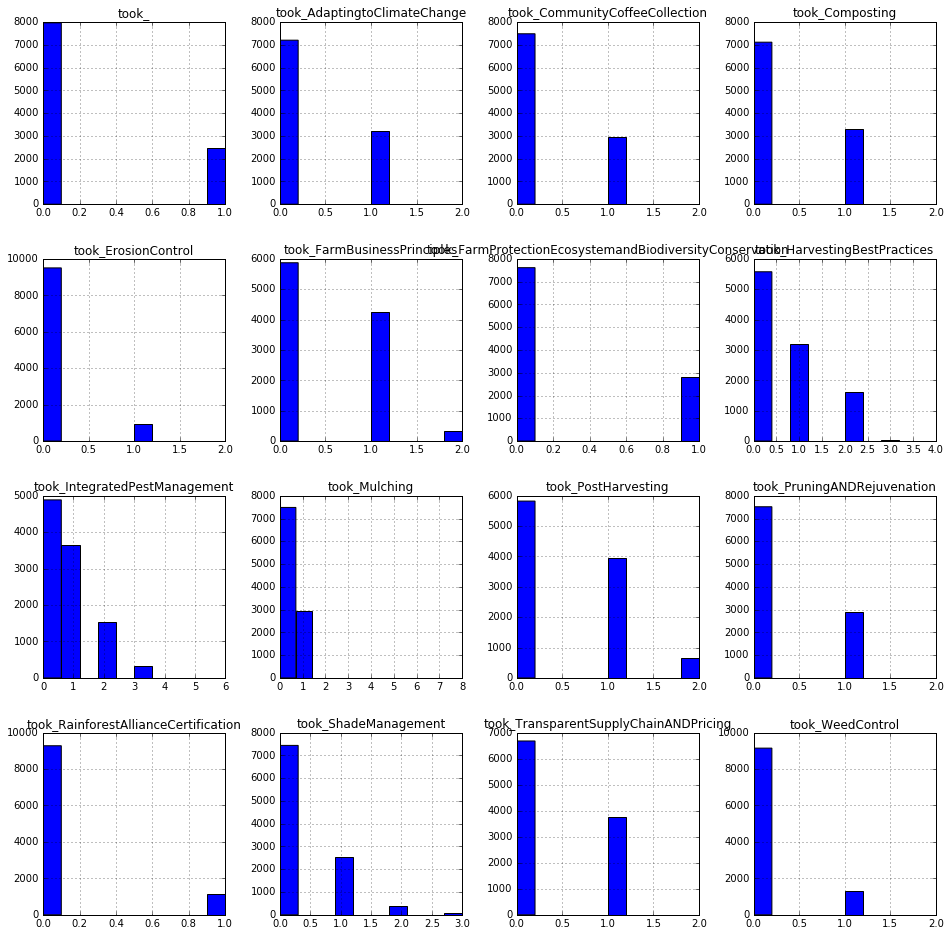

In [76]:
farmers_trees.loc[:,'took_':].hist(figsize=[16,16])

In [77]:
for c in courses:
    farmers_trees[c+'_twiceOrMore'] = farmers_trees['took_'+c].apply(lambda x: int(x > 1))
    farmers_trees[c+'_atLeastOnce'] = farmers_trees['took_'+c].apply(lambda x: int(x > 0))

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

treats = [c+'_atLeastOnce' for c in courses][1:]
print "\nVariance Inflation Factors:\n"
for i in range(len(treats)):
    print treats[i] + " " + str(variance_inflation_factor(farmers_trees[treats].as_matrix(),i))
print "\nThe treatments do not appear to be too highly multicollinear :)"


Variance Inflation Factors:

ShadeManagement_atLeastOnce 1.971274753
WeedControl_atLeastOnce 2.41775379449
IntegratedPestManagement_atLeastOnce 3.99701826798
AdaptingtoClimateChange_atLeastOnce 2.4529495766
FarmProtectionEcosystemandBiodiversityConservation_atLeastOnce 2.79362630563
Composting_atLeastOnce 2.42874396285
TransparentSupplyChainANDPricing_atLeastOnce 2.39031801021
ErosionControl_atLeastOnce 1.57370927161
PruningANDRejuvenation_atLeastOnce 2.56838340076
Mulching_atLeastOnce 3.09489318016
HarvestingBestPractices_atLeastOnce 3.91590841751
PostHarvesting_atLeastOnce 3.3419006929
RainforestAllianceCertification_atLeastOnce 1.80578713286
CommunityCoffeeCollection_atLeastOnce 2.07371367188
FarmBusinessPrinciples_atLeastOnce 2.68610850127

The treatments do not appear to be too highly multicollinear :)


# FEATURE ENGINEERING (Courses/Attendance/Adoption/Trees)

In [148]:
farmers_trees['course_diversity']=farmers_trees[treats].sum(axis=1)
farmers_trees['course_diversity X Adoption'] = farmers_trees['course_diversity']*farmers_trees['Adoption']

treatsXadoption = []
for t in treats:
    farmers_trees[t+' X Adoption'] = farmers_trees[t]*farmers_trees['Adoption']
    treatsXadoption = treatsXadoption + [t+' X Adoption']

farmers_trees['Trees_log'] = farmers_trees['Trees'].apply(np.log)
farmers_trees['Trees_sqrt'] = farmers_trees['Trees'].apply(np.sqrt)

# STRATIFICATION: Station $\supset$ Staff $\supset$ Group $\supset$ Farm (observation)

In [64]:
# farms are nested in groups
# groups are nested with in staff
# staff are nested within a Station
farmers_trees.Station.unique()
farmers_trees.Staff.unique()
pd.pivot_table(farmers_trees[['Station','Staff','intercept']], values=['intercept'], index=['Staff'], columns=['Station'], aggfunc=np.sum)

intercept                                          \
Station                  Gikomero Huye Mountain Coffee Kabonobono  Muhura   
Staff                                                                       
Annociata Uwimana             NaN                  NaN        NaN     NaN   
Gasangwa Gustave              NaN                523.0        NaN     NaN   
Habonimana Venuste            NaN                103.0        NaN     NaN   
Hakizimana Augustin           NaN                  NaN        NaN     NaN   
Karambizi Narcisse            NaN                  NaN        NaN     NaN   
MUKASHYAKA Christine          NaN                  NaN        NaN     NaN   
Mugabufitake J. de Dieu       NaN                  NaN      802.0     NaN   
Mugema Emmanuel               NaN                467.0        NaN     NaN   
Mukunzi Fidele                NaN                187.0        NaN     NaN   
Nathan Shyirambere            NaN                  NaN        NaN     NaN   
Niyitegeka Gilbert            NaN                  NaN        NaN     NaN   
Nyirahabimana Charlotte       NaN                  NaN        NaN     NaN   
Nyiranshuti Janviere          NaN                223.0        NaN     NaN   
Twagiruwijuru Emmanuel      758.0                  NaN        NaN     NaN   
Twizeyimana Deo            1035.0                  NaN        NaN     NaN   
Ubarijoro Innocent            NaN                  NaN        NaN   886.0   
Uwiringiyimana Joyce          NaN                  NaN        NaN  1073.0   
Uwizeyimana Francoise         NaN                  NaN      422.0     NaN   
Uwizeyimana Rachel            NaN                 57.0        NaN     NaN   

                                                             
Station                 Nyungwe High Coffee Shyara Mountain  
Staff                                                        
Annociata Uwimana                       NaN           727.0  
Gasangwa Gustave                        NaN             NaN  
Habonimana Venuste                      NaN             NaN  
Hakizimana Augustin                     NaN           728.0  
Karambizi Narcisse                      NaN           312.0  
MUKASHYAKA Christine                    NaN           544.0  
Mugabufitake J. de Dieu                 NaN             NaN  
Mugema Emmanuel                         NaN             NaN  
Mukunzi Fidele                          NaN             NaN  
Nathan Shyirambere                      NaN           450.0  
Niyitegeka Gilbert                    568.0             NaN  
Nyirahabimana Charlotte               571.0             NaN  
Nyiranshuti Janviere                    NaN             NaN  
Twagiruwijuru Emmanuel                  NaN             NaN  
Twizeyimana Deo                         NaN             NaN  
Ubarijoro Innocent                      NaN             NaN  
Uwiringiyimana Joyce                    NaN             NaN  
Uwizeyimana Francoise                   NaN             NaN  
Uwizeyimana Rachel                      NaN             NaN

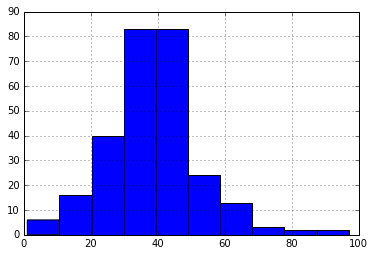

In [60]:
# farms are put in groups
farmers_trees.groupby(['Group ID']).size().hist()

In [61]:
number_groups = farmers_trees[['Staff','Group ID']].groupby(['Staff']).agg(lambda x: len(x['Group ID'].unique()))
number_farms = farmers_trees[['Staff']].groupby(['Staff']).size()

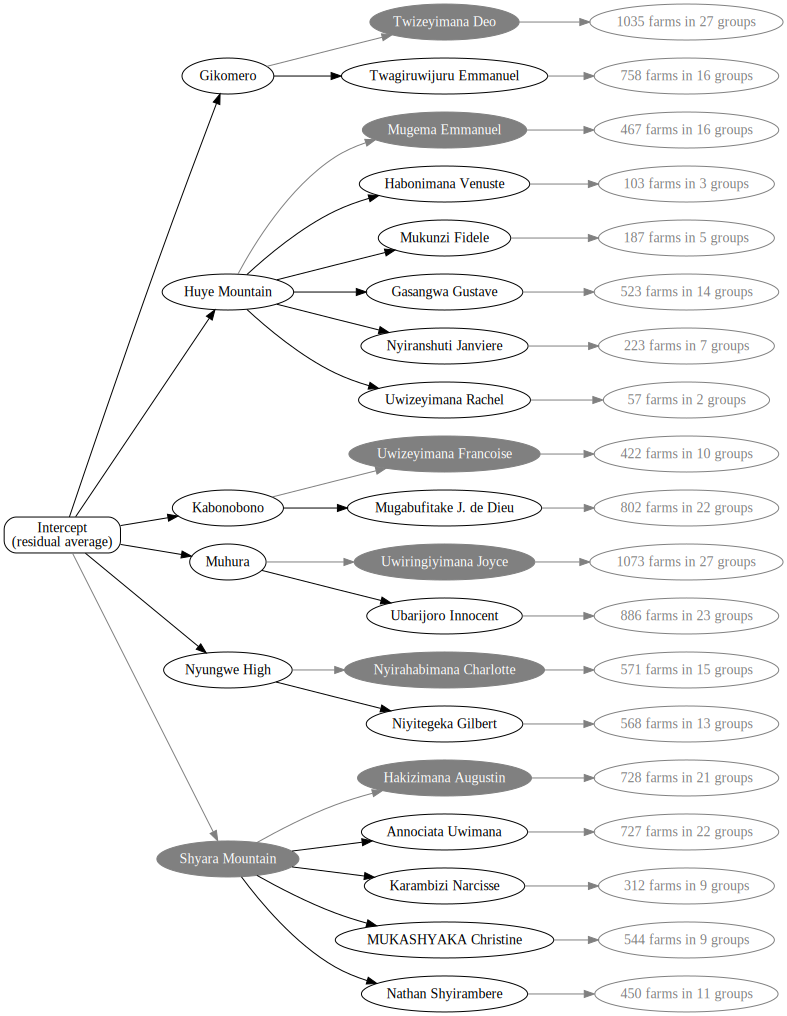

In [62]:
# conda install graphviz
# pip install graphviz
from graphviz import Digraph
g = Digraph()

g.node('int',label='Intercept\n(residual average)', shape="box", style="rounded")

g.node('Gikomero')
g.node('Twizeyimana Deo', style='filled', fillcolor='gray', fontcolor='white', color="gray")
g.node('Twagiruwijuru Emmanuel')
g.edge('Gikomero', 'Twizeyimana Deo', color='gray')
g.edge('Gikomero', 'Twagiruwijuru Emmanuel')       

g.node('Huye Mountain')#Coffee
g.node('Mugema Emmanuel', style='filled', fillcolor='gray', fontcolor='white', color="gray")
g.node('Habonimana Venuste')
g.node('Mukunzi Fidele')
g.node('Gasangwa Gustave')
g.node('Nyiranshuti Janviere')
g.node('Uwizeyimana Rachel')
g.edge('Huye Mountain', 'Gasangwa Gustave')
g.edge('Huye Mountain', 'Habonimana Venuste')      
g.edge('Huye Mountain', 'Mugema Emmanuel', color='gray')
g.edge('Huye Mountain', 'Mukunzi Fidele')
g.edge('Huye Mountain', 'Nyiranshuti Janviere')      
g.edge('Huye Mountain', 'Uwizeyimana Rachel')       
    
g.node('Kabonobono')
g.node('Uwizeyimana Francoise', style='filled', fillcolor='gray', fontcolor='white', color="gray")
g.node('Mugabufitake J. de Dieu')
g.edge('Kabonobono', 'Uwizeyimana Francoise', color='gray')    
g.edge('Kabonobono', 'Mugabufitake J. de Dieu')
       
g.node('Muhura')
g.node('Uwiringiyimana Joyce', style='filled', fillcolor='gray', fontcolor='white', color="gray")
g.node('Ubarijoro Innocent')
g.edge('Muhura', 'Uwiringiyimana Joyce', color='gray')
g.edge('Muhura', 'Ubarijoro Innocent')

g.node('Nyungwe High') #Coffee
g.node('Nyirahabimana Charlotte', style='filled', fillcolor='gray', fontcolor='white', color="gray")
g.node('Niyitegeka Gilbert ')
g.edge('Nyungwe High', 'Nyirahabimana Charlotte', color='gray')
g.edge('Nyungwe High', 'Niyitegeka Gilbert ')

g.node('Shyara Mountain', style='filled', fillcolor='gray', fontcolor='white', color="gray")
g.node('Hakizimana Augustin', style='filled', fillcolor='gray', fontcolor='white', color="gray")
g.node('Annociata Uwimana')
g.node('Karambizi Narcisse')
g.node('MUKASHYAKA Christine ')
g.node('Nathan Shyirambere')
g.edge('Shyara Mountain','Hakizimana Augustin', color='gray')
g.edge('Shyara Mountain','Annociata Uwimana')
g.edge('Shyara Mountain','Karambizi Narcisse')
g.edge('Shyara Mountain','MUKASHYAKA Christine ')
g.edge('Shyara Mountain','Nathan Shyirambere')

g.edge('int', 'Gikomero')
g.edge('int', 'Huye Mountain')
g.edge('int', 'Kabonobono')
g.edge('int', 'Muhura')
g.edge('int', 'Nyungwe High')
g.edge('int', 'Shyara Mountain', color='gray')

for staff in number_farms.index:
    tmp=str(number_farms[staff])+" farms in "+str(number_groups[number_groups.index == staff].values[0][0])+" groups"
    g.node(tmp, fontcolor='gray', color="gray")
    g.edge(staff, tmp, color="gray")
    
g.graph_attr['rankdir'] = 'LR'
g

# Nested structure multicollinearity requires special attention
# But can be addressed with proper variable encoding scheme

In [70]:
farmers_trees = farmers_trees.join(pd.get_dummies(farmers_trees['Group ID']), how='inner')
farmers_trees = farmers_trees.join(pd.get_dummies(farmers_trees['Staff']), how='inner')
farmers_trees = farmers_trees.join(pd.get_dummies(farmers_trees['Station']), how='inner')
farmers_trees.columns

Index([u'Station', u'Staff', u'Group ID', u'Farmer Name', u'Attendance',
       u'Adoption', u'2015', u'2016', u'Course Attended', u'Trees',
       ...
       u'Ubarijoro Innocent', u'Uwiringiyimana Joyce',
       u'Uwizeyimana Francoise', u'Uwizeyimana Rachel', u'Gikomero',
       u'Huye Mountain Coffee', u'Kabonobono', u'Muhura',
       u'Nyungwe High Coffee', u'Shyara Mountain'],
      dtype='object', length=318)

In [106]:
groups = list(farmers_trees['Group ID'].unique())
treats_groups = treats+groups[1:]#+['intercept']
print len(treats_groups), len(groups), len(groups)

print "\nIncrease in Treatment Variance Inflation Factors with all group stratification:\n"
for i in range(len(treats)):
    vif_t = np.round(variance_inflation_factor(farmers_trees[treats].as_matrix(),i),2)
    vif_tg = np.round(variance_inflation_factor(farmers_trees[treats_groups].as_matrix(),i),2)
    print str(vif_t) + " -> " + str(vif_tg) + " (" + treats[i] + ")"

286 272 272

Increase in Treatment Variance Inflation Factors with all group stratification:

1.97 -> 3.38 (ShadeManagement_atLeastOnce)
2.42 -> 4.66 (WeedControl_atLeastOnce)
4.0 -> 5.46 (IntegratedPestManagement_atLeastOnce)
2.45 -> 3.35 (AdaptingtoClimateChange_atLeastOnce)
2.79 -> 3.68 (FarmProtectionEcosystemandBiodiversityConservation_atLeastOnce)
2.43 -> 3.24 (Composting_atLeastOnce)
2.39 -> 3.6 (TransparentSupplyChainANDPricing_atLeastOnce)
1.57 -> 2.16 (ErosionControl_atLeastOnce)
2.57 -> 3.64 (PruningANDRejuvenation_atLeastOnce)
3.09 -> 5.51 (Mulching_atLeastOnce)
3.92 -> 6.39 (HarvestingBestPractices_atLeastOnce)
3.34 -> 4.09 (PostHarvesting_atLeastOnce)
1.81 -> 3.15 (RainforestAllianceCertification_atLeastOnce)
2.07 -> 3.5 (CommunityCoffeeCollection_atLeastOnce)
2.69 -> 3.69 (FarmBusinessPrinciples_atLeastOnce)


# Model Building

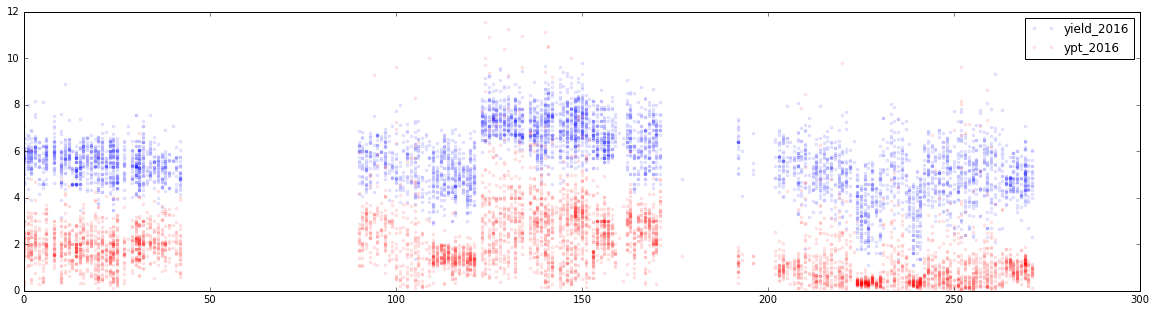

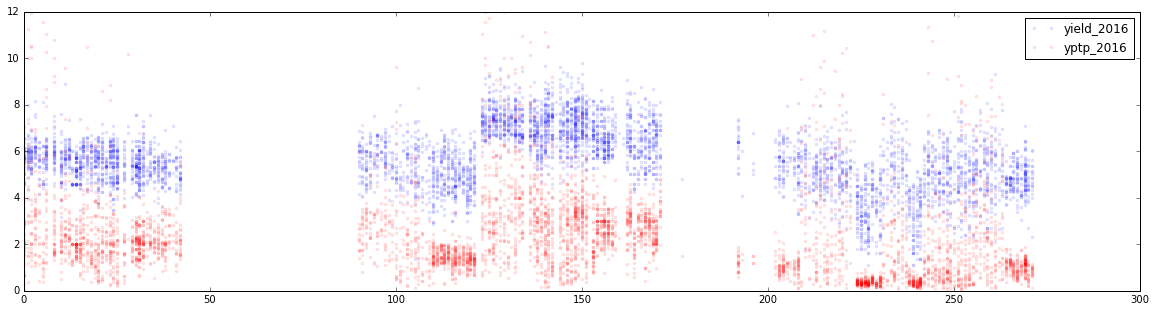

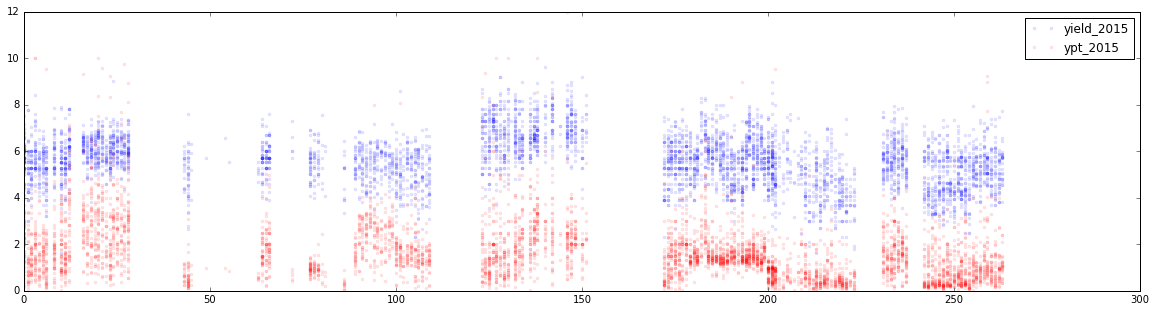

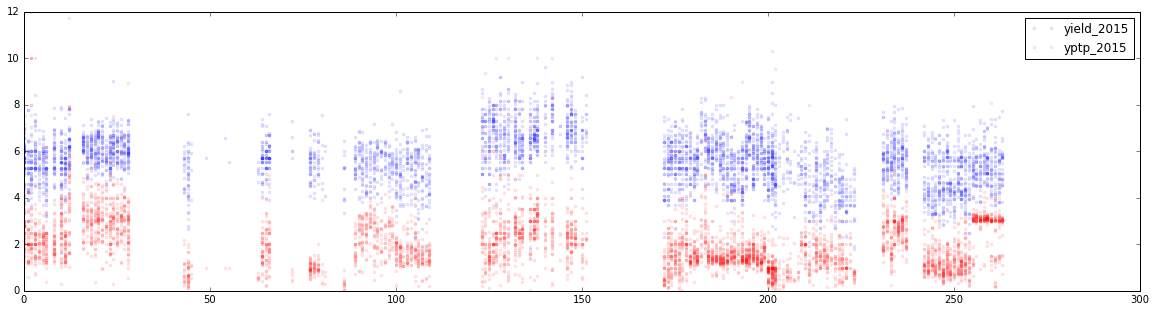

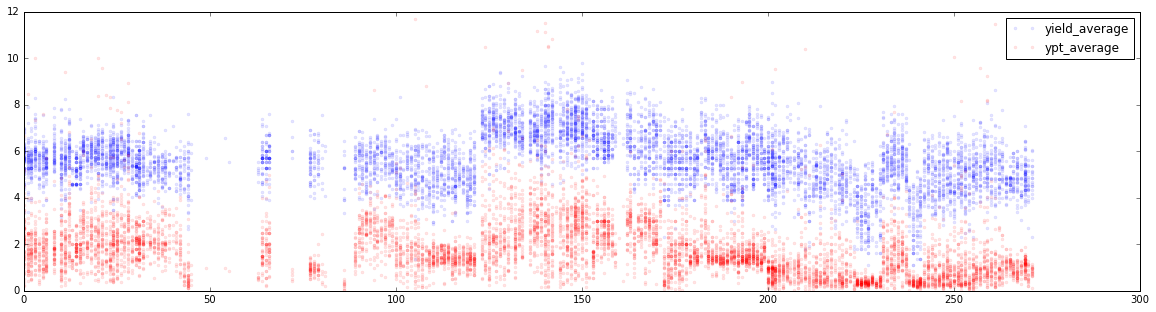

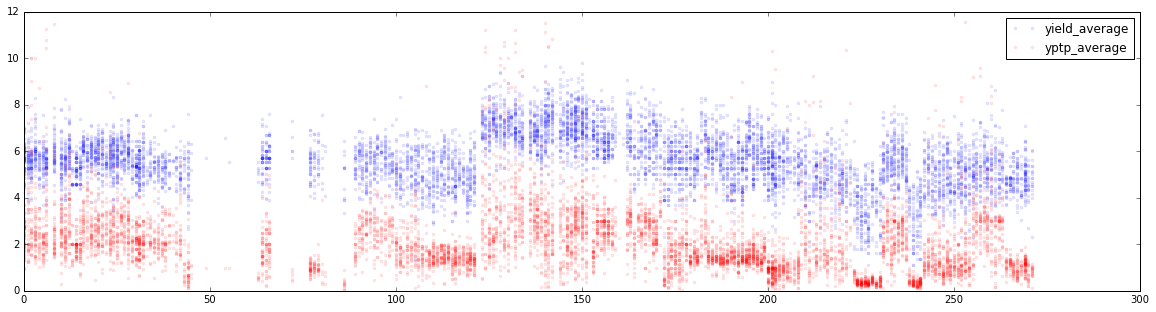

In [110]:
# per tree measurements have heteroskedasticity issues...
for y in ['2016', '2015', 'average']:
    for yp in ['ypt_', 'yptp_']:
        plt.figure(figsize=[20,5])
        plt.plot(farmers_trees['Group ID'].astype('category').cat.codes,farmers_trees['yield_'+y].apply(np.log), 'b.', alpha=.1, label='yield_'+y)
        plt.plot(farmers_trees['Group ID'].astype('category').cat.codes,farmers_trees[yp+y], 'r.', alpha=.1, label=yp+y)
        plt.legend(loc="best")
        plt.ylim([0,12])

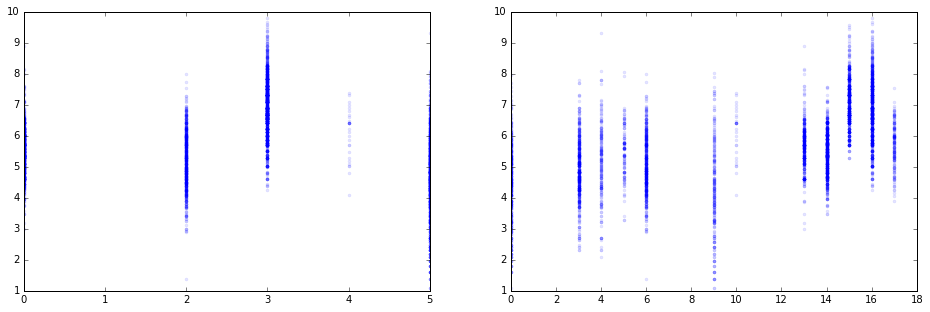

In [119]:
# systematic differences at higher levels as well
# as seen later adjustment at these levels will not be sufficient
plt.figure(figsize=[16,5])
plt.subplot(121)
plt.plot(farmers_trees['Station'].astype('category').cat.codes,farmers_trees['yield_2016'].apply(np.log), 'b.', alpha=.1)
plt.subplot(122)
plt.plot(farmers_trees['Staff'].astype('category').cat.codes,farmers_trees['yield_2016'].apply(np.log), 'b.', alpha=.1)

In [159]:
staffers = list(farmers_trees['Staff'].unique())
regions = list(farmers_trees['Station'].unique())

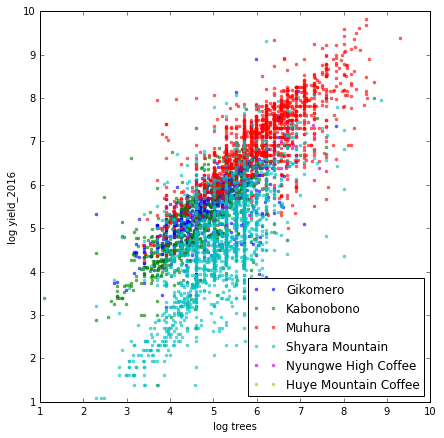

In [160]:
outcome = 'yield_2016'
plt.figure(figsize=[7,7])
for region in regions:
    plt.plot(farmers_trees.Trees[farmers_trees[region]==1].apply(np.log),
             farmers_trees.ix[farmers_trees[region]==1, outcome].apply(np.log),
             '.',label=region,alpha=.6)
plt.xlabel("log trees"); plt.ylabel("log " + outcome); plt.legend(loc='best')

In [177]:
Trees_logXregion = []
for region in regions:
    Trees_logXregion = Trees_logXregion + ['Trees_log X ' + region]
    farmers_trees['Trees_log X ' + region] = farmers_trees['Trees_log']*farmers_trees[region] 
Trees_logXregion    

['Trees_log X Gikomero',
 'Trees_log X Kabonobono',
 'Trees_log X Muhura',
 'Trees_log X Shyara Mountain',
 'Trees_log X Nyungwe High Coffee',
 'Trees_log X Huye Mountain Coffee']

In [235]:
from statsmodels.regression.linear_model import OLS

outcome = 'yield_2016'
farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees', 'Group ID']]
farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID']]
farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + regions[1:4]]
farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + regions[1:4] + Trees_logXregion[1:4]]
farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + Trees_logXregion[1:4] + staffers[:11]]
farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + Trees_logXregion[1:4] + groups ]

#farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + ['course_diversity'] + Trees_logXregion[1:4] + groups ]
#farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + ['Adoption', 'course_diversity', 'course_diversity X Adoption'] + Trees_logXregion[1:4] + groups ]
#farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + ['Adoption', 'course_diversity', 'course_diversity X Adoption'] + Trees_logXregion[1:4]]
#farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + ['course_diversity X Adoption'] + Trees_logXregion[1:4] + groups ]

farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + treats + Trees_logXregion[1:4] + groups ]
#farmers_trees_use = farmers_trees[[outcome, 'intercept', 'Trees_log', 'Group ID'] + treatsXadoption + Trees_logXregion[1:4] + groups ]

farmers_trees_use = farmers_trees_use.replace([np.inf],np.nan).dropna()
y = farmers_trees_use[outcome].apply(np.log)
x = farmers_trees_use.ix[:,(farmers_trees_use.columns != outcome)&(farmers_trees_use.columns != 'Group ID')]

if 1==0:
    for r in range(10):
        model = OLS(y, x, hasconst=True, missing='drop')
        results = model.fit()
        diagnostics = OLSInfluence(results)
        y = y[diagnostics.cooks_distance[0]<4./len(y)]
        x = x[diagnostics.cooks_distance[0]<4./len(x)]
        farmers_trees_use = farmers_trees_use[diagnostics.cooks_distance[0]<4./len(farmers_trees_use)]

model = OLS(y, x, hasconst=True, missing='drop')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             yield_2016   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     405.2
Date:                Sun, 18 Dec 2016   Prob (F-statistic):               0.00
Time:                        19:48:28   Log-Likelihood:                -722.77
No. Observations:                4426   AIC:                             1858.
Df Residuals:                    4220   BIC:                             3175.
Df Model:                         205                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------------------
intercept                                                          0.8052      0.037     22.038      0.000         0.734     0.877
Trees_log                                                          0.8114      0.014     56.145      0.000         0.783     0.840
ShadeManagement_atLeastOnce                                        0.0173      0.017      1.007      0.314        -0.016     0.051
WeedControl_atLeastOnce                                           -0.0329      0.089     -0.371      0.710        -0.207     0.141
IntegratedPestManagement_atLeastOnce                              -0.0002      0.020     -0.012      0.990        -0.040     0.040
AdaptingtoClimateChange_atLeastOnce                               -0.0054      0.016     -0.343      0.731        -0.037     0.026
FarmProtectionEcosystemandBiodiversityConservation_atLeastOnce    -0.0281      0.016     -1.796      0.073        -0.059     0.003
Composting_atLeastOnce                                             0.0140      0.017      0.800      0.424        -0.020     0.048
TransparentSupplyChainANDPricing_atLeastOnce                       0.0096      0.017      0.550      0.582        -0.025     0.044
ErosionControl_atLeastOnce                                         0.0070      0.018      0.379      0.705        -0.029     0.043
PruningANDRejuvenation_atLeastOnce                                 0.0038      0.018      0.207      0.836        -0.032     0.039
Mulching_atLeastOnce                                              -0.0054      0.087     -0.062      0.950        -0.177     0.166
HarvestingBestPractices_atLeastOnce                                0.0514      0.020      2.579      0.010         0.012     0.090
PostHarvesting_atLeastOnce                                        -0.0582      0.017     -3.372      0.001        -0.092    -0.024
RainforestAllianceCertification_atLeastOnce                        0.1293      0.029      4.413      0.000         0.072     0.187
CommunityCoffeeCollection_atLeastOnce                             -0.0642      0.018     -3.595      0.000        -0.099    -0.029
FarmBusinessPrinciples_atLeastOnce                                -0.0245      0.014     -1.698      0.090        -0.053     0.004
Trees_log X Kabonobono                                             0.0780      0.021      3.720      0.000         0.037     0.119
Trees_log X Muhura                                                 0.0263      0.017      1.535      0.125        -0.007     0.060
Trees_log X Shyara Mountain                                        0.2640      0.020     13.324      0.000         0.225     0.303
GG001                                                              0.9

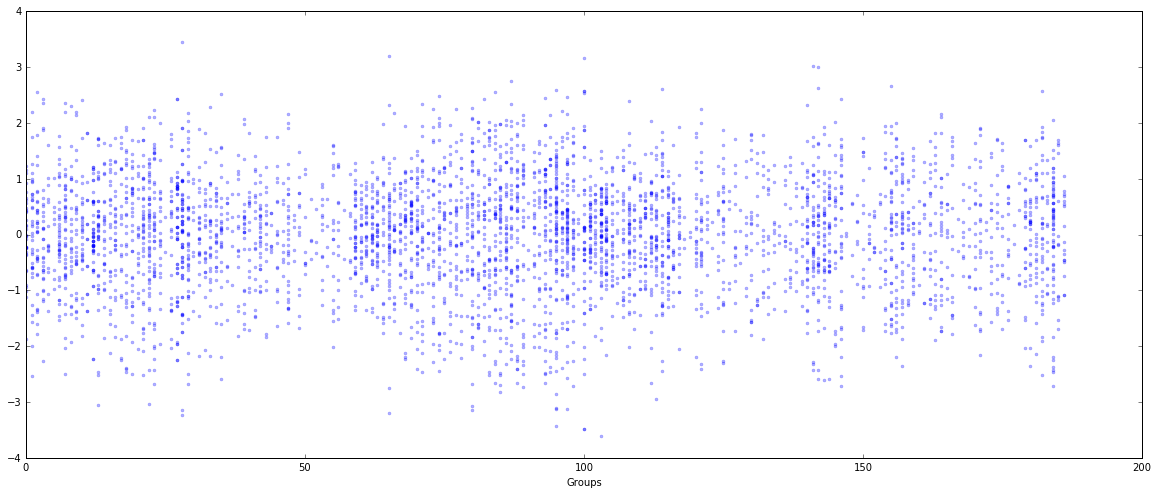

In [236]:
from statsmodels.stats.outliers_influence import OLSInfluence

diagnostics = OLSInfluence(results)
plt.figure(figsize=[20,8]) #Average Yield
plt.plot(farmers_trees_use['Group ID'].astype('category').cat.codes,diagnostics.resid_studentized_internal, 'b.', alpha=.3)
plt.ylim([-4,4]); plt.xlabel("Groups")

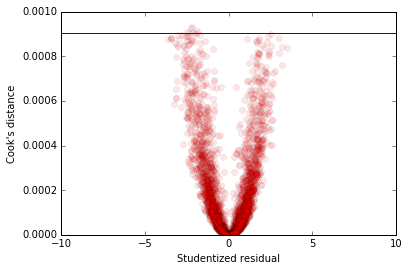

In [237]:
diagnostics = OLSInfluence(results)

plt.plot(diagnostics.resid_studentized_internal, diagnostics.cooks_distance[0], 'ro', alpha=.1)
plt.plot([-10,10],2*[4./len(diagnostics.resid_studentized_internal)])
plt.xlabel("Studentized residual"); plt.ylabel("Cook's distance")

# SCRATCH WORK: IN PROGRESS/IRRELEVANT

In [ ]:
if 1==0:
    for r in range(20):
        model = OLS(y, x, hasconst=True, missing='drop')
        results = model.fit()
        diagnostics = OLSInfluence(results)
        y = y[diagnostics.cooks_distance[0]<4./len(y)]
        x = x[diagnostics.cooks_distance[0]<4./len(x)]

In [ ]:
import seaborn as sns
sns.heatmap(farmers_trees[treats].corr())

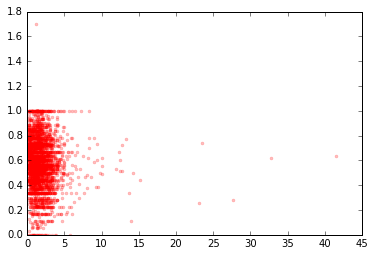

In [125]:
#plt.plot(farmers_trees['ypt_2015'],farmers_trees['Attendance'],'b.',alpha=.25)
plt.plot(farmers_trees['ypt_2015'],farmers_trees['Adoption'],'r.',alpha=.25)
#plt.xlim([0,5])
#plt.ylim([0,1])

(0, 1000)

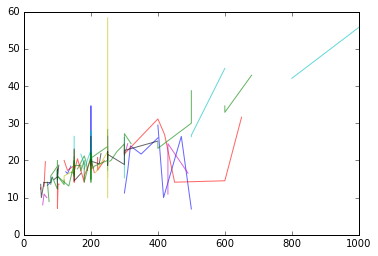

In [149]:
for region in groups[:10]:
    a = farmers_trees.Trees[farmers_trees[region]==1]
    b = farmers_trees.yield_2016[farmers_trees[region]==1].apply(np.sqrt)
    c=np.argsort(a)
    plt.plot(a[c], b[c], label=region,alpha=.6)

plt.xlim([0,1000])

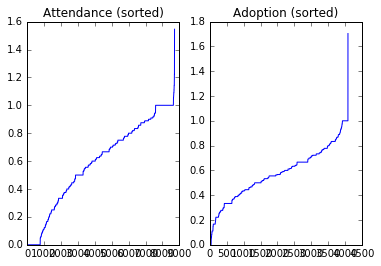

In [206]:
plt.subplot(121)
plt.plot(sorted(farmers['Attendance'].dropna()))#.unique()
plt.title('Attendance (sorted)')
plt.subplot(122)
plt.plot(sorted(farmers['Adoption'].dropna()))#.unique()
plt.title('Adoption (sorted)')

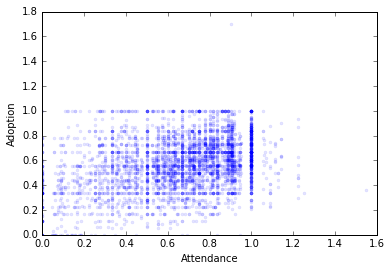

In [207]:
plt.plot(farmers['Attendance'],farmers['Adoption'], '.', alpha=.1)
plt.xlabel('Attendance')
plt.ylabel('Adoption')

In [ ]:
regions = pd.get_dummies(farmers.Station)
del regions['Shyara Mountain'] # referent
staffer = pd.get_dummies(farmers.Staff)
del staffer['Twizeyimana Deo'] # Gikomero referent
del staffer['Mugema Emmanuel']# Huye Mountain Coffee referent
del staffer['Uwizeyimana Francoise']# Kabonobono Mountain Coffee referent
del staffer['Uwiringiyimana Joyce'] # Muhura referent
del staffer['Nyirahabimana Charlotte']# Nyungwe High Coffee referent
del staffer['Hakizimana Augustin']# Shyara Mountain referent

In [ ]:
print regions_staffer.columns
regions_staffer_names = np.array([
'Gikomero - Twizeyimana Deo',
'Huye Mountain Coffee - Mugema Emmanuel', 
'Kabonobono - Uwizeyimana Francoise', 
'Muhura - Uwiringiyimana Joyce',
'Nyungwe High Coffee - Nyirahabimana Charlotte', 
'Annociata Uwimana - Shyara Mountain', 
'Gasangwa Gustave - Huye Mountain',
'Habonimana Venuste - Huye Mountain',
'Karambizi Narcisse - Shyara Mountain', 
'MUKASHYAKA Christine - Shyara Mountain',
'Mugabufitake J. de Dieu - Kabonobono', 
'Mukunzi Fidele - Huye Mountain', 
'Nathan Shyirambere - Shyara Mountain', 
'Niyitegeka Gilbert - Nyungwe High',
'Nyiranshuti Janviere - Huye Mountain', 
'Twagiruwijuru Emmanuel - Gikomero', 
'Ubarijoro Innocent - Muhura',
'Uwizeyimana Rachel - Huye Mountain'])

# Mugema Emmanuel - Huye Mountain: Gasangwa Gustave
# Uwizeyimana Francoise - Kabonobono: ugabufitake J. de Die

regions_staffer_order=[5,8,9,12, 0,15, 1,6,7,11,14,17, 2,10, 3,16, 4,13]
regions_staffer_names[regions_staffer_order]
# Intercept "Shyara Mountain - Hakizimana Augustin"

In [ ]:
farmers.rename(columns={'intercept': 'intercept - Shyara Mountain - Hakizimana Augustin'}, inplace=True)
farmers.columns

In [ ]:
regions_staffer_names[regions_staffer_order]
regions_staffer_order

In [ ]:
for i in regions_staffer_order:
    farmers[regions_staffer_names[i]] = regions_staffer[regions_staffer.columns[i]]
    #del farmers[regions_staffer_names[i]]
    
#del farmers['Mugema Emmanuel - Huye Mountain']
#del farmers['Uwizeyimana Francoise - Kabonobono'] 
    
farmers.columns   

In [ ]:
from statsmodels.regression.linear_model import OLS

features = list(regions_staffer_names[regions_staffer_order])
y = farmers['Average Yield']
x = farmers[['intercept - Shyara Mountain - Hakizimana Augustin']+features]

model = OLS(y, x, hasconst=True, missing='drop')
results = model.fit()
results.summary()

In [ ]:
features = [# intercept: 'Annociata Uwimana - Shyara Mountain'
#'Annociata Uwimana - Shyara Mountain',
 'Karambizi Narcisse - Shyara Mountain',
 'MUKASHYAKA Christine - Shyara Mountain',
 'Nathan Shyirambere - Shyara Mountain',
 'Gikomero - Twizeyimana Deo',#'Twagiruwijuru Emmanuel - Gikomero'
#'Twagiruwijuru Emmanuel - Gikomero',
 'Huye Mountain Coffee - Mugema Emmanuel',#Uwizeyimana Rachel - Huye Mountain', 'Mukunzi Fidele - Huye Mountain',
#'Gasangwa Gustave - Huye Mountain',
#'Habonimana Venuste - Huye Mountain',
#'Mukunzi Fidele - Huye Mountain',
## 'Nyiranshuti Janviere - Huye Mountain',
#'Uwizeyimana Rachel - Huye Mountain',
 'Kabonobono - Uwizeyimana Francoise',
 'Mugabufitake J. de Dieu - Kabonobono',
 'Muhura - Uwiringiyimana Joyce',
 'Ubarijoro Innocent - Muhura',
 'Nyungwe High Coffee - Nyirahabimana Charlotte',
 'Niyitegeka Gilbert - Nyungwe High']

In [ ]:
features = [#intercept #Shyara Mountain + Gikomero & Huye Mountain Coffee & Kabonobono
#'Annociata Uwimana - Shyara Mountain',
#'Karambizi Narcisse - Shyara Mountain',
#'MUKASHYAKA Christine - Shyara Mountain',
#'Nathan Shyirambere - Shyara Mountain',
#'Gikomero - Twizeyimana Deo', #'Twagiruwijuru Emmanuel - Gikomero',
#'Twagiruwijuru Emmanuel - Gikomero',
#'Huye Mountain Coffee - Mugema Emmanuel',#'all below
#'Gasangwa Gustave - Huye Mountain',
#'Habonimana Venuste - Huye Mountain',
#'Mukunzi Fidele - Huye Mountain', 
#'Nyiranshuti Janviere - Huye Mountain',
#'Uwizeyimana Rachel - Huye Mountain',
#'Kabonobono - Uwizeyimana Francoise',#'Mugabufitake J. de Dieu - Kabonobono',
#'Mugabufitake J. de Dieu - Kabonobono',
 'Muhura - Uwiringiyimana Joyce',
 'Ubarijoro Innocent - Muhura',
 'Nyungwe High Coffee - Nyirahabimana Charlotte',
 'Niyitegeka Gilbert - Nyungwe High']

In [ ]:
y = farmers['Average Yield']
x = farmers[['intercept - Shyara Mountain - Hakizimana Augustin']+features+freatures_courses]

model = OLS(y, x, hasconst=True, missing='drop')
results = model.fit()
results.summary()